In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import numpy as np
import os
import time
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Dense, Activation, Flatten, GlobalMaxPooling2D, Dropout
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import GlobalAveragePooling2D, Dense

In [4]:
from sklearn.model_selection import train_test_split

np_X = np.load('/content/drive/My Drive/transfer_learning_data/orthodontics/np_total.npy').astype(float)
np_Y = np.load('/content/drive/My Drive/transfer_learning_data/orthodontics/np_label.npy').astype(float)
X_train, X_test, Y_train, Y_test = train_test_split(np_X, np_Y, test_size=0.15, random_state=777)
X_train, X_validate, Y_train, Y_validate = train_test_split(X_train, Y_train, test_size=0.15, random_state=777)

In [5]:
num_classes=2
names=['Orthodontics', 'Normal']
Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_validate = np_utils.to_categorical(Y_validate, num_classes)
Y_test = np_utils.to_categorical(Y_test, num_classes)

In [6]:
print('Training Data: {}'.format(X_train.shape))
print('Test Data: {}'.format(X_validate.shape))
print(sum(Y_train==0))

Training Data: (738, 224, 224, 3)
Test Data: (131, 224, 224, 3)
[267 471]


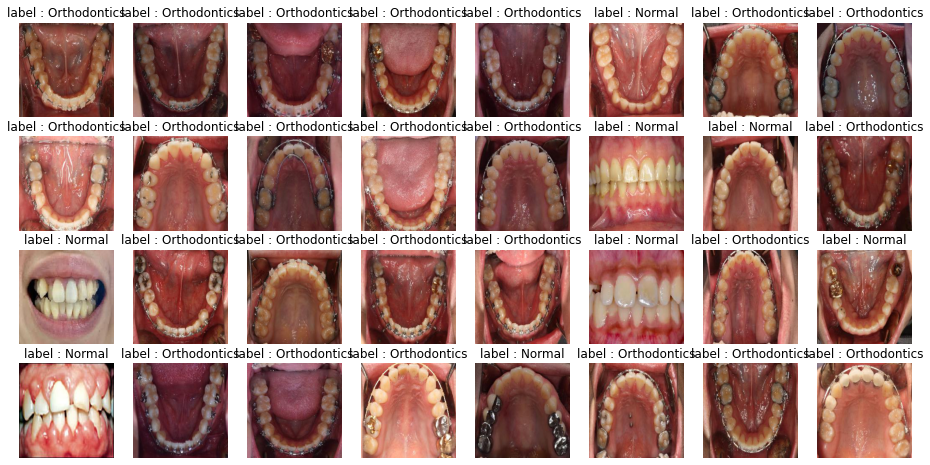

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
for k in range(32):
    img = X_train[k]
    label = Y_train[k]
    plt.subplot(4,8,1+k)
    plt.imshow(img)
    plt.axis('off')
    plt.title('label : {0}'.format(names[np.argmax(label)]))
plt.show()

In [9]:
model = MobileNetV2(include_top=True, weights='imagenet')

x=Dense(num_classes,activation='sigmoid',name='predictions')(model.layers[-2].output) # softmax로 해도 상관없음.
custom_mobilenetv2_model = Model(model.input, x)

for layer in custom_mobilenetv2_model.layers[:-1]:
  layer.trainable=False

custom_mobilenetv2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

custom_mobilenetv2_model.summary()

14540800/14536120 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________

In [10]:
n_epochs = 50
n_batch = 32

In [12]:
from keras.callbacks import EarlyStopping
early=EarlyStopping(monitor='val_loss', patience=13, verbose=1) # patience=13이면, loss가 증가한다고 바로 training을 멈추는 것이 아니라 몇번 지켜보다가 개선가능성이 없으면 멈춤. 

t=time.time()
hist = custom_mobilenetv2_model.fit(X_train, Y_train, batch_size=n_batch, epochs=n_epochs, verbose=1, validation_data=(X_validate, Y_validate), callbacks=[early])
print('Training time: %s' % (t - time.time()))

Epoch 1/50
24/24 [==============================] - 2s 72ms/step - loss: 0.4573 - accuracy: 0.8008 - val_loss: 0.2418 - val_accuracy: 0.9389
Epoch 2/50
24/24 [==============================] - 1s 35ms/step - loss: 0.1984 - accuracy: 0.9404 - val_loss: 0.1745 - val_accuracy: 0.9389
Epoch 3/50
24/24 [==============================] - 1s 35ms/step - loss: 0.1566 - accuracy: 0.9472 - val_loss: 0.1461 - val_accuracy: 0.9466
Epoch 4/50
24/24 [==============================] - 1s 36ms/step - loss: 0.1340 - accuracy: 0.9512 - val_loss: 0.1299 - val_accuracy: 0.9466
Epoch 5/50
24/24 [==============================] - 1s 36ms/step - loss: 0.1184 - accuracy: 0.9607 - val_loss: 0.1167 - val_accuracy: 0.9466
Epoch 6/50
24/24 [==============================] - 1s 36ms/step - loss: 0.1050 - accuracy: 0.9621 - val_loss: 0.1076 - val_accuracy: 0.9618
Epoch 7/50
24/24 [==============================] - 1s 36ms/step - loss: 0.0956 - accuracy: 0.9688 - val_loss: 0.0976 - val_accuracy: 0.9695
Epoch 8/50
24

In [15]:
(loss, accuracy) = custom_mobilenetv2_model.evaluate(X_test, Y_test, batch_size=n_batch, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

custom_mobilenetv2_model.save('/content/drive/My Drive/mobilenetv2_orthodontics_cam.h5')

5/5 [==============================] - 0s 23ms/step - loss: 0.0302 - accuracy: 0.9870
[INFO] loss=0.0302, accuracy: 98.7013%


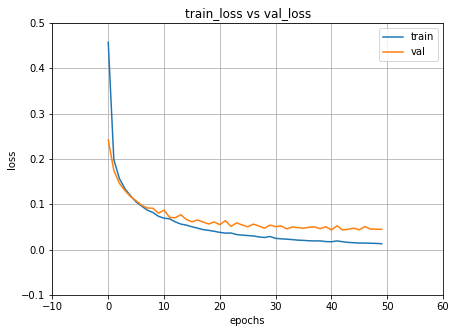

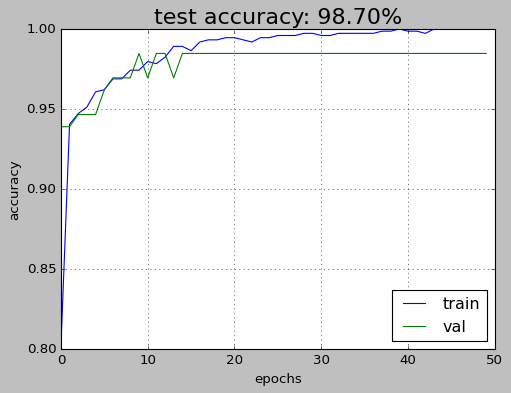

In [14]:
import matplotlib.pyplot as plt
% matplotlib inline
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
xc=range(len(train_loss))

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('test accuracy: {:.2f}%'.format(accuracy*100), fontsize=20)
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.show()